In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

2022-12-24 10:12:56.536199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 10:12:56.688388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-24 10:12:56.688406: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-24 10:12:56.718633: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-24 10:12:57.572281: W tensorflow/stream_executor/platform/de

## Reading

In [2]:
df = pd.read_csv("oasis_longitudinal.csv")

In [20]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [19]:
df["Visit"].diff().head()

0    NaN
1    1.0
2   -1.0
3    1.0
4    1.0
Name: Visit, dtype: float64

In [27]:
df_visit = pd.DataFrame((df["Visit"].diff() != 1) & (df["Visit"].diff() > 0))

In [29]:
df_visit[df_visit["Visit"] == True]

,Visit
11,True
30,True
34,True
69,True
188,True
274,True


In [32]:
index_visit_problem = df_visit[df_visit["Visit"] == True].index

In [33]:
df.loc[index_visit_problem,:]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
11,OAS2_0007,OAS2_0007_MR3,Demented,3,518,M,R,73,16,NaN,27.0,1.0,1365,0.727,1.286
30,OAS2_0017,OAS2_0017_MR3,Nondemented,3,617,M,R,81,12,3.0,27.0,0.5,1814,0.759,0.968
34,OAS2_0018,OAS2_0018_MR3,Converted,3,489,F,R,88,14,1.0,29.0,0.0,1398,0.713,1.255
69,OAS2_0036,OAS2_0036_MR3,Nondemented,3,713,F,R,70,13,4.0,30.0,0.0,1361,0.783,1.290
188,OAS2_0089,OAS2_0089_MR3,Demented,3,563,M,R,72,12,2.0,27.0,1.0,1432,0.684,1.226
274,OAS2_0133,OAS2_0133_MR3,Converted,3,1006,F,R,81,12,3.0,28.0,0.5,1495,0.687,1.174


In [34]:
df.iloc[9:15,:]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033
10,OAS2_0007,OAS2_0007_MR1,Demented,1,0,M,R,71,16,NaN,28.0,0.5,1357,0.748,1.293
11,OAS2_0007,OAS2_0007_MR3,Demented,3,518,M,R,73,16,NaN,27.0,1.0,1365,0.727,1.286
12,OAS2_0007,OAS2_0007_MR4,Demented,4,1281,M,R,75,16,NaN,27.0,1.0,1372,0.710,1.279
13,OAS2_0008,OAS2_0008_MR1,Nondemented,1,0,F,R,93,14,2.0,30.0,0.0,1272,0.698,1.380
14,OAS2_0008,OAS2_0008_MR2,Nondemented,2,742,F,R,95,14,2.0,29.0,0.0,1257,0.703,1.396


In [35]:
df.iloc[273:276,:]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
273,OAS2_0133,OAS2_0133_MR1,Converted,1,0,F,R,78,12,3.0,29.0,0.0,1475,0.731,1.190
274,OAS2_0133,OAS2_0133_MR3,Converted,3,1006,F,R,81,12,3.0,28.0,0.5,1495,0.687,1.174
275,OAS2_0134,OAS2_0134_MR1,Demented,1,0,F,R,70,11,4.0,29.0,0.5,1295,0.748,1.355


<AxesSubplot:>

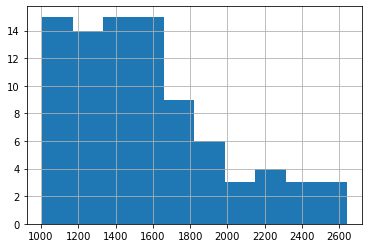

In [37]:
df[df["MR Delay"] > 1000]["MR Delay"].hist()

In [270]:
# Author: amyrmahdy
# Date: 24 Dec 2022